In [1]:
import cv2

img = cv2.imread('images/solar_Fri_Jun_16_6__0__25_2017_L_0.0901960784314_I_0.003.jpg')
# img=cv2.imread('images/tree.jpg')
# img=cv2.imread('images/out3.jpg')

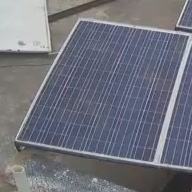

(192, 192, 3)

In [2]:
import IPython

def imshow(img):
    returnValue, buffer = cv2.imencode('.jpg', img)
    IPython.display.display(IPython.display.Image(data=buffer.tobytes()))

imshow(img)

height, width, channels = img.shape
img.shape

In [3]:
import numpy as np
import time

def ps_filter(img):
    #Sobel Hor filter  
    kernelV    = np.array([[-1.0,-2.0,-1.0],[0.0,0.0,0.0],[1.0,2.0,1.0]],np.float32)
    kernelH    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
    kernelG    = np.array([[1.0,2.0,1.0],[2.0,4.0,2.0],[1.0,2.0,1.0]],np.float32)
    kernelD   = np.ones((3,3),np.uint8)
    buf       = np.ones((height,width),np.uint8)
    frame_out = np.ones((height,width),np.uint8)

    num_frames    = 20

    gaussian_kernel = cv2.getGaussianKernel(5,3)
#     print(gaussian_kernel)
    # kernel_2D = gaussian_kernel @ gaussian_kernel.transpose()

    start = time.time()
    frame_in_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # cv2.filter2D(img, -1, kernelG, buf, borderType=cv2.BORDER_CONSTANT)
    blurred=cv2.filter2D(img, -1, gaussian_kernel)
#     cv2.dilate(buf, kernelD, frame_out, borderType=cv2.BORDER_CONSTANT)
#     imshow(blurred)

    time_sw_total = time.time() - start
    print("Time Taken: {} ".format(time_sw_total))

In [4]:
# print(open('prunSW','r').read())
# res = !cat prunSW | grep filter2D | awk '{{print $$2}}'
# tottime_sw_filter2d = float(res[0])
# res = !cat prunSW | grep dilate   | awk '{{print $$2}}'
# tottime_sw_dilate   = float(res[0])

In [5]:
import cv2 #NOTE: This needs to be loaded first

# Load filter2D + dilate overlay
from pynq import Overlay
bs = Overlay("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.bit")
bs.download()
import pynq_cv.overlays.xv2Filter2DDilate as xv2

# Load xlnk memory manager
from pynq import Xlnk
Xlnk.set_allocator_library('/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.so')
mem_manager = Xlnk()

In [6]:
import numpy as np
import time
import multiprocessing
from multiprocessing.pool import ThreadPool

def stream_fpga_filter(img):
    kernelF    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
    kernelVoid = np.zeros(0)
    xFin       = mem_manager.cma_array((height,width),np.uint8)
    xFbuf      = mem_manager.cma_array((height,width),np.uint8)
    xFout      = mem_manager.cma_array((height,width),np.uint8)

#     num_frames       = 20

#     xFin[:]    = frame_in_gray[:]
    start = time.time()
    for _ in range(10):
        frame_in_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        xFin[:]       = frame_in_gray[:]
        
        xv2.filter2D(xFin, -1, kernelF, xFbuf, borderType=cv2.BORDER_CONSTANT)
        xv2.dilate(xFbuf, kernelVoid, xFout, borderType=cv2.BORDER_CONSTANT)
        
#         frame_out[:]  = xFout[:]
#         imshow(xFout[:])
    time_hw_total = time.time() - start
    print("Time Taken:  " + str(time_hw_total))

def fpga_filter(img):
    kernelF    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
    kernelVoid = np.zeros(0)
    xFin       = mem_manager.cma_array((height,width),np.uint8)
    xFbuf      = mem_manager.cma_array((height,width),np.uint8)
    xFout      = mem_manager.cma_array((height,width),np.uint8)

#     num_frames       = 20

#     xFin[:]    = frame_in_gray[:]
    start = time.time()
    frame_in_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    xFin[:]       = frame_in_gray[:]

    xv2.filter2D(xFin, -1, kernelF, xFbuf, borderType=cv2.BORDER_CONSTANT)
    xv2.dilate(xFbuf, kernelVoid, xFout, borderType=cv2.BORDER_CONSTANT)

#         frame_out[:]  = xFout[:]
#         imshow(xFout[:])
    time_hw_total = time.time() - start
    print("Time Taken:  " + str(time_hw_total))

# Single Processing

In [7]:
print('time taken for small image')
num_iterations=10
print("Time taken on PS with Single Processing for {} Iterations".format(num_iterations))
start_time=time.time()
for i in range(num_iterations):
    ps_filter(img)
print('Time taken for non-parallel execution: {}'.format(time.time()-start_time))

num_iterations=10
print("Time taken on FPGA with stream Single Processing for {} Iterations".format(num_iterations))
start_time=time.time()
# for i in range(num_iterations):
stream_fpga_filter(img)
print('Time taken for non-parallel execution: {}'.format(time.time()-start_time))

print("Time taken on FPGA with stream Single Processing for {} Iterations".format(num_iterations))
start_time=time.time()
for i in range(num_iterations):
    fpga_filter(img)
print('Time taken for non-parallel execution: {}'.format(time.time()-start_time))


time taken for small image
Time taken on PS with Single Processing for 10 Iterations
Time Taken: 0.006550788879394531 
Time Taken: 0.004167318344116211 
Time Taken: 0.004126310348510742 
Time Taken: 0.00412297248840332 
Time Taken: 0.004111289978027344 
Time Taken: 0.004312276840209961 
Time Taken: 0.0041675567626953125 
Time Taken: 0.004239797592163086 
Time Taken: 0.00424647331237793 
Time Taken: 0.004132270812988281 
Time taken for non-parallel execution: 0.054035186767578125
Time taken on FPGA with stream Single Processing for 10 Iterations
Time Taken:  0.00857853889465332
Time taken for non-parallel execution: 0.020228147506713867
Time taken on FPGA with stream Single Processing for 10 Iterations
Time Taken:  0.0010950565338134766
Time Taken:  0.0009419918060302734
Time Taken:  0.0008866786956787109
Time Taken:  0.0008885860443115234
Time Taken:  0.0008800029754638672
Time Taken:  0.0008878707885742188
Time Taken:  0.0008831024169921875
Time Taken:  0.0008842945098876953
Time Take

# Multi-Processing

In [8]:
print("Time taken on PS with Multi-Processing for {} Iterations".format(num_iterations))
pool=multiprocessing.Pool()
start_time=time.time()
pool.map(fpga_filter, [img]*num_iterations)
print('Time taken for multi-processing= {}'.format(time.time()-start_time))


print("Time taken on FPGA with Multi-Processing for {} Iterations".format(num_iterations))
pool=multiprocessing.Pool()
start_time=time.time()
pool.map(fpga_filter, [img]*num_iterations)
print('Time taken for multi-processing= {}'.format(time.time()-start_time))

Time taken on PS with Multi-Processing for 10 Iterations
Time Taken:  0.0016961097717285156
Time Taken:  0.0015499591827392578
Time Taken:  0.0016782283782958984
Time Taken:  0.0016951560974121094
Time Taken:  0.0010998249053955078
Time Taken:  0.001111745834350586
Time Taken:  0.0009851455688476562
Time Taken:  0.0009829998016357422
Time Taken:  0.0033261775970458984
Time Taken:  0.0033118724822998047
Time taken for multi-processing= 0.08086419105529785
Time taken on FPGA with Multi-Processing for 10 Iterations
Time Taken:  0.0012235641479492188
Time Taken:  0.0013508796691894531
Time Taken:  0.001840829849243164
Time Taken:  0.001967906951904297
Time Taken:  0.0010333061218261719
Time Taken:  0.0009682178497314453
Time Taken:  0.0011513233184814453
Time Taken:  0.0009584426879882812
Time Taken:  0.0011272430419921875
Time Taken:  0.0008995532989501953
Time taken for multi-processing= 0.06435513496398926
